In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-dark')

In [2]:
boston = load_boston()
X_array = boston.data
y_array = boston.target
df = pd.DataFrame(X_array, columns = boston.feature_names).assign(Price=np.array(y_array))

print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0000)
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=0000)

X_train = df_train.drop('Price', axis = 1)
y_train = df_train['Price']
X_valid = df_valid.drop('Price', axis = 1)
y_valid = df_valid['Price']
X_test = df_test.drop('Price', axis = 1)
y_test = df_test['Price']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)
lgb_test = lgb.Dataset(X_test, y_test)

In [16]:
if 'opt_lgb_model' in locals():
    params = opt_lgb_model.params
else:
    params = {'task': 'train',
              'objective': 'regression',
              'boosting': 'gbdt',
              'metric' : 'rmse',
              'verbosity': -1,
              'randomseed': 0000}

In [17]:
evals_result = {}
lgb_model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_valid],
                      valid_names=['train', 'valid'],
                      num_boost_round=1000,
                      early_stopping_rounds=100,
                      evals_result=evals_result,
                      verbose_eval=100)

/home/p/miniconda3/envs/env1/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/p/miniconda3/envs/env1/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.533384	valid's rmse: 2.54638
[200]	train's rmse: 0.133502	valid's rmse: 2.53744
[300]	train's rmse: 0.0475265	valid's rmse: 2.53223
Early stopping, best iteration is:
[296]	train's rmse: 0.0490601	valid's rmse: 2.53198


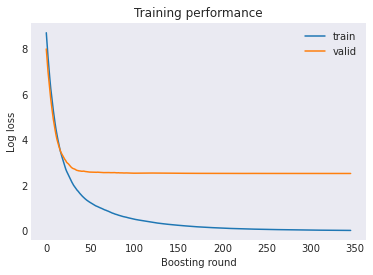

In [18]:
# show learning loss
plt.plot(evals_result['train']['rmse'], label='train')
plt.plot(evals_result['valid']['rmse'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [19]:
y_pred = lgb_model.predict(X_test)
df_pred = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1)
df_pred.columns = ['true', 'pred']

df_pred.head()

,true,pred
0,22.6,24.727236
1,50.0,25.613089
2,23.0,24.384112
3,8.3,8.565183
4,21.2,21.348007


In [20]:
def calc_score(df):
    MSE = mean_squared_error(df['true'], df['pred'])
    RMSE = np.sqrt(mean_squared_error(df['true'], df['pred']))
    MAE = mean_absolute_error(df['true'], df['pred'])
    R2 = r2_score(df['true'], df['pred'])
    eval_result = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'R2'])
    eval_result.loc['MLDEL'] = np.round(MSE), np.round(RMSE), np.round(MAE), np.round(R2, decimals=4)

    return eval_result

eval_result = calc_score(df_pred)
eval_result

,MSE,RMSE,MAE,R2
MLDEL,19.0,4.0,3.0,0.7744


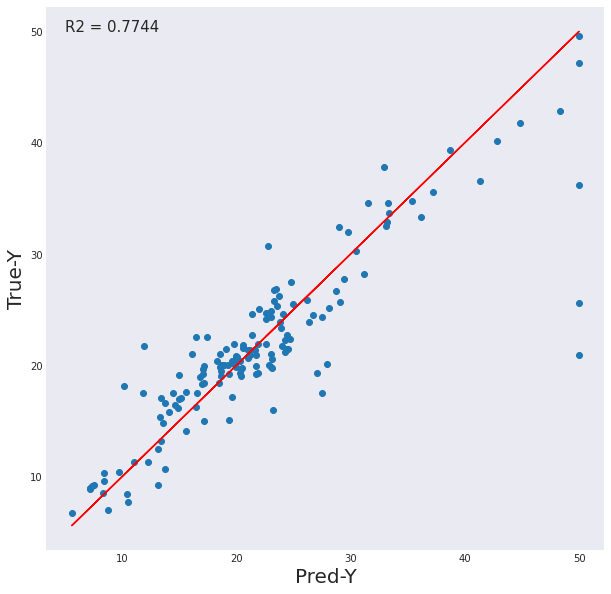

In [21]:
def yy_plot(df, idx='R2'):
    plt.figure(figsize = (10,10))
    plt.plot(df['true'], df['true'], color = 'red', label = 'x=y')
    plt.scatter('true', 'pred', data=df)
    plt.xlabel('Pred-Y', fontsize=20)
    plt.ylabel('True-Y', fontsize=20)
    plt.text(5, 50, '{} = {}'.format(idx, eval_result[idx][0]), fontsize=15)

yy_plot(df_pred, 'R2')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

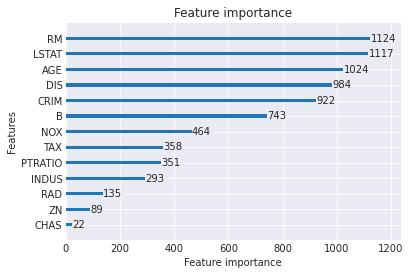

In [22]:
lgb.plot_importance(lgb_model, importance_type='split')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

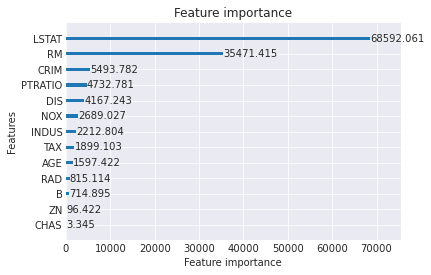

In [23]:
lgb.plot_importance(lgb_model, importance_type='gain')

# Optuna

In [12]:
import optuna.integration.lightgbm as opt_lgb

In [13]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0000)
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=0000)

X_train = df_train.drop('Price', axis = 1)
y_train = df_train['Price']
X_valid = df_valid.drop('Price', axis = 1)
y_valid = df_valid['Price']
X_test = df_test.drop('Price', axis = 1)
y_test = df_test['Price']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)
lgb_test = lgb.Dataset(X_test, y_test)

In [14]:
params = {'objective': 'regression',
          'metric': 'rmse',
          'verbosity': -1,
          'random_seed': 1234}

opt_lgb_model = opt_lgb.train(params=params,
                              train_set=lgb_train,
                              valid_sets=[lgb_train, lgb_valid],
                              valid_names=['train', 'valid'],
                              num_boost_round=1000,
                              early_stopping_rounds=50,
                              verbose_eval=0)

[I 2021-07-31 00:16:39,002] A new study created in memory with name: no-name-05b8e1cb-f923-4a37-ac85-42945c9134b6
min_data_in_leaf, val_score: 2.531984: 100%|##########| 5/5 [00:01<00:00,  3.38it/s]


In [15]:
opt_lgb_model.params

{'objective': 'regression',
 'metric': 'rmse',
 'verbosity': -1,
 'random_seed': 1234,
 'feature_pre_filter': False,
 'lambda_l1': 0.046424366748553984,
 'lambda_l2': 5.590964604426086,
 'num_leaves': 27,
 'feature_fraction': 0.8,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 5,
 'num_iterations': 1000,
 'early_stopping_round': 50}

# SHAP
- [リファレンス](https://shap.readthedocs.io/en/latest/index.html)
- [参考](https://blog.amedama.jp/entry/shap-lightgbm)

In [24]:
import shap

In [25]:
shap.initjs()

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_train)

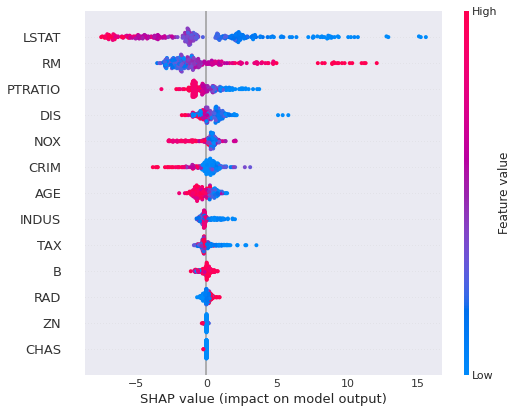

In [26]:
shap.summary_plot(shap_values=shap_values,
                  features=X_train,
                  feature_names=X_train.columns)

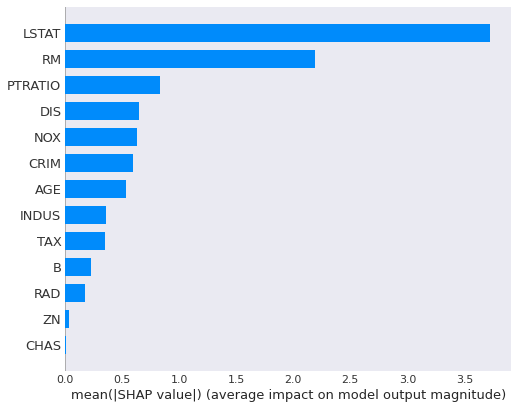

In [27]:
shap.summary_plot(shap_values=shap_values,
                  features=X_train,
                  feature_names=X_train.columns,
                  plot_type='bar')

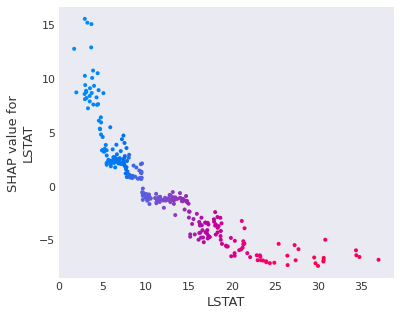

In [28]:
shap.dependence_plot(ind='LSTAT',
                     interaction_index='LSTAT',
                     shap_values=shap_values,
                     features=X_train,
                     feature_names=X_train.columns)

In [29]:
shap.force_plot(base_value=explainer.expected_value,
                shap_values=shap_values,
                features=X_train,
                feature_names=X_train.columns)

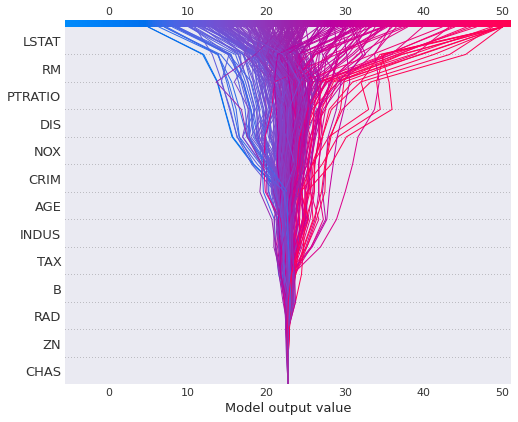

In [30]:
shap.decision_plot(base_value=explainer.expected_value,
                  shap_values=shap_values,
                  features=X_train,
                  feature_names=list(X_train.columns))